In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

from numpy.random import default_rng
RANDOM_STATE = 2 # random state for default_rng
rng = default_rng(RANDOM_STATE)


import random
#import memory_profiler
import altair as alt
from tqdm import tqdm
import datetime

# CHECKLIST for Kaggle variant
# USE_ALL_STOCK_IDS False to check then True
# USE_TEST_LOCAL_6_ITEMS must be False else we override the locl test data
# TEST_SIZE must be 0 to get all items
# Check on Kaggle that "internet" is disabled

t1_notebook_start = datetime.datetime.utcnow()

if os.environ.get('USER') == 'ian':
    ENV_HOME = True
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_ALL_STOCK_IDS = False
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    TEST_SIZE = 0.25
    USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
    #USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home TEMPORARY WHILST DEBUGGING
else:
    ENV_HOME = False
    USE_ALL_STOCK_IDS = False # for KAGGLE on first-upload for a quick test
    TEST_SIZE = 0
    USE_TEST_LOCAL_6_ITEMS = False
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


if USE_ALL_STOCK_IDS:
    NBR_FOR_SUBSET_OF_STOCK_IDS=None
print(f'ENV_HOME: {ENV_HOME}, TEST_SIZE {TEST_SIZE}, USE_ALL_STOCK_IDS {USE_ALL_STOCK_IDS}, USE_TEST_LOCAL_6_ITEMS {USE_TEST_LOCAL_6_ITEMS}')
print(f'NBR_FOR_SUBSET_OF_STOCK_IDS: {NBR_FOR_SUBSET_OF_STOCK_IDS}')

ENV_HOME: True, TEST_SIZE 0.25, USE_ALL_STOCK_IDS False, USE_TEST_LOCAL_6_ITEMS True
NBR_FOR_SUBSET_OF_STOCK_IDS: 4
In [1] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 135.04 MiB


In [2]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_training_stock_ids
from utility import ROOT, TEST_CSV, TRAIN_CSV

Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
In [2] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 135.04 MiB


## Load train set

In [3]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default

if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print(f"Using a subset of {NBR_FOR_SUBSET_OF_STOCK_IDS}")
    rng.shuffle(stock_ids)
    #random.shuffle(stock_ids)
    stock_ids = stock_ids[:NBR_FOR_SUBSET_OF_STOCK_IDS]
else:
    print("Using all")
stock_ids[:3] # expect 59, 58, 23 if we're using all or 76, 73, 0 on the RANDOM_STATE of 1 if we don't use all stock ids

Using a subset of 4


[119, 2, 16]

In [3] used 0.5039 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 135.55 MiB


In [4]:
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
print(df_train_all.shape)
#rows_for_stock_id_0 = df_train_all.query('stock_id == 0').shape[0]
#rows_for_stock_id_0

(428932, 1)
In [4] used 22.4805 MiB RAM in 0.29s, peaked 14.75 MiB above current, total RAM usage 158.03 MiB


In [5]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'    
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}')

show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [5] used 0.0586 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 158.09 MiB


In [6]:
all_time_ids = df_train_all.reset_index().time_id.unique()
#np.random.shuffle(all_time_ids) # shuffle the time_ids
rng.shuffle(all_time_ids)
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2,872 for train and 958 for test
Example time ids for training, min first: [5, 11, 16, 31, 62]
In [6] used -6.3711 MiB RAM in 0.12s, peaked 6.37 MiB above current, total RAM usage 151.71 MiB


In [7]:
# make feature columns
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1

In [7] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 151.71 MiB


In [8]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [8] used 0.0195 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 151.73 MiB


In [83]:
def realized_volatility_weighted(ser, weights=None):
    """Weighted volatility"""
    #ser = series_log_return
    if weights == "uniform":
        weight_arr = np.ones(ser.shape[0])
    elif weights == 'linear':
        weight_arr = np.linspace(0.1, 1, ser.shape[0]) # linear increasing weight
    #assert weights is not None, "Must have set a valid description before here"
    #ser_weighted = ser * weights
    return np.sqrt(np.sum((ser * weight_arr)**2))

if True:
    # example usage
    series_log_return = np.linspace(0, 10, 6)
    weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight

    half_way = int(series_log_return.shape[0] / 2)
    weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight

    weights = np.ones(series_log_return.shape[0]) # use all items equally
    assert weights.shape[0] == series_log_return.shape[0]
    realized_volatility_weighted(series_log_return, 'linear')

In [83] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 692.15 MiB


In [84]:
def make_wap(df_book_data, num=1, wap_colname="wap"):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data[wap_colname] = wap_numerator / wap_denominator

def make_realized_volatility(df_book_data, log_return_name='log_return', wap_colname='wap', weights=None):
    """Consume wap column"""
    df_book_data[log_return_name] = df_book_data.groupby(['stock_id', 'time_id'])[wap_colname].apply(log_return)
    df_book_data = df_book_data[~df_book_data[log_return_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[log_return_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

In [84] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 692.15 MiB


In [11]:
if True: # lightweight tests
    df_book_train_stock_XX = pd.read_parquet(os.path.join(ROOT, f"book_train.parquet/stock_id=0"))
    df_book_train_stock_XX["stock_id"] = 0
    df_book_train_stock_XX = df_book_train_stock_XX.set_index(['stock_id', 'time_id'])
    make_wap(df_book_train_stock_XX, 2) # adds 'wap' column
    df_realized_vol_per_stockXX = make_realized_volatility(df_book_train_stock_XX, log_return_name="log_return2", weights='linear')
    display(df_realized_vol_per_stockXX)

log_return2
stock_id time_id             
0        5           0.004500
         11          0.001749
         16          0.003284
         31          0.002465
         62          0.001806
...                       ...
         32751       0.002343
         32753       0.001905
         32758       0.002118
         32763       0.003160
         32767       0.001316

[3830 rows x 1 columns]

In [11] used 168.7148 MiB RAM in 4.65s, peaked 54.09 MiB above current, total RAM usage 320.69 MiB


In [87]:
def load_data_build_features(stock_id, ROOT, filename, cols, df_target):
    # filename e.g. book_train.parquet
    assert isinstance(stock_id, int)
    df_book_train_stock_X = pd.read_parquet(
        os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
    )
    df_book_train_stock_X["stock_id"] = stock_id
    df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
    #assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)
    
    #df_book_train_stock_X_gt500 = df_book_train_stock_X.query("seconds_in_bucket>500").copy()
    #df_realized_vol_per_stock_short500 = add_wap_make_realized_volatility(df_book_train_stock_X_gt500, log_return_name='log_return_gt500sec')
    #df_book_train_stock_X_gt300 = df_book_train_stock_X.query("seconds_in_bucket>300").copy()
    #df_realized_vol_per_stock_short300 = add_wap_make_realized_volatility(df_book_train_stock_X_gt300, log_return_name='log_return_gt300sec')
    make_wap(df_book_train_stock_X, 2, "wap2") 
    df_realized_vol_per_stock_wap2_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_uniform", wap_colname="wap2", weights='uniform')    
    df_realized_vol_per_stock_wap2_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_linear", wap_colname="wap2", weights='linear')
    make_wap(df_book_train_stock_X, 1, "wap") # adds 'wap' column
    df_realized_vol_per_stock_wap1_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_uniform", weights='uniform')
    df_realized_vol_per_stock_wap1_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_linear", weights='linear')
    features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
    #print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
    features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)
    features_size1 = make_features_stats(df_book_train_stock_X, 'size', cols)
    
    df_train_stock_X = df_target.query('stock_id == @stock_id')
    to_merge = [df_train_stock_X, features_var1, features_mean1, features_size1, 
                df_realized_vol_per_stock_wap1_uniform,
                df_realized_vol_per_stock_wap2_uniform,
                df_realized_vol_per_stock_wap1_linear,
                df_realized_vol_per_stock_wap2_linear]
                #df_realized_vol_per_stock_num1, df_realized_vol_per_stock_num2, 
                #df_realized_vol_per_stock_num1_linear_weight]
                #df_realized_vol_per_stock_short300, df_realized_vol_per_stock_short500, ]
    row_lengths = [df.shape[0] for df in to_merge]
    assert len(set(row_lengths)) == 1, row_lengths # should all be same length
    train_merged = pd.concat(to_merge, axis=1)
    return train_merged

print(f'Iterating over {len(stock_ids)} stocks:')
    
cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',] 
cols += ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
#cols += ['wap', 'wap_numerator', 'wap_denominator']

if True:    
    # test...
    train_mergedXX = load_data_build_features(0, ROOT, 'book_train.parquet', cols, df_train_all)
    display(train_mergedXX)

Iterating over 4 stocks:


target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
0        5        0.004136    3.557702e-07    3.609267e-07    3.278967e-07   
         11       0.001445    8.048454e-08    4.782809e-08    5.987733e-08   
         16       0.002168    5.057495e-07    6.204843e-07    5.307066e-07   
         31       0.002195    4.746649e-07    3.223060e-07    5.349445e-07   
         62       0.001747    4.740689e-08    3.653909e-08    5.247379e-08   
...                    ...             ...             ...             ...   
         32751    0.002611    3.989057e-07    5.059281e-07    3.846314e-07   
         32753    0.001190    1.837252e-07    2.433933e-07    2.033434e-07   
         32758    0.004264    5.668076e-07    4.536424e-07    6.043470e-07   
         32763    0.004352    1.058614e-07    1.051107e-07    1.070506e-07   
         32767    0.001084    5.710588e-07    5.752923e-07    6.009845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
0        5          3.649655e-07    6592.215309    4338.669743    7348.756507   
         11         4.715270e-08   15492.325402    9691.320578    8465.001985   
         16         6.152997e-07    4978.115912    9259.747269    5674.860251   
         31         3.222207e-07    8093.880602   10996.043697    5778.103922   
         62         3.838027e-08    9499.414513    9603.210909    7059.243117   
...                          ...            ...            ...            ...   
         32751      4.818288e-07    9490.991605   10394.996610    4828.041246   
         32753      2.618266e-07   28270.493701   20407.077646   15863.063249   
         32758      4.448702e-07    6587.428917    7851.263511    2219.748436   
         32763      1.431541e-07    7244.247983    6607.922889    8062.183603   
         32767      5.970896e-07    9402.179206   10214.490359   12848.133608   

                  ask_size2_var  bid_price1_mean  ...  ask_price2_mean  \
stock_id time_id                                  ...                    
0        5          5184.163572         1.003314  ...         1.004320   
         11         7875.531633         1.000011  ...         1.000541   
         16         4586.227415         0.999204  ...         1.000127   
         31         6483.167437         0.998445  ...         0.999413   
         62         4527.422208         0.999407  ...         0.999913   
...                         ...              ...  ...              ...   
         32751      9333.874374         0.997639  ...         0.998372   
         32753     10575.195643         1.000141  ...         1.000856   
         32758      5428.886648         0.999334  ...         0.999941   
         32763      5552.617083         1.002087  ...         1.002734   
         32767      6756.769515         0.998886  ...         0.999471   

                  bid_size1_mean  ask_size1_mean  bid_size2_mean  \
stock_id time_id                                                   
0        5             78.264901       74.579470       80.880795   
         11           149.965000       71.145000       95.445000   
         16            96.132979      131.037234      114.526596   
         31           114.458333      120.800000       68.783333   
         62           119.823864       88.477273       87.840909   
...                          ...             ...             ...   
         32751        110.929293       87.632997       61.488215   
         32753        113.325243      228.140777      157.121359   
         32758         77.175532      100.904255       61.074468   
         32763        113.019544       83.853420      104.254072   
         32767        155.267544      137.372807      146.171053   

                  ask_size2_mean  size  log_return1_uniform  \
stock_id time_id                        

In [87] used -19.9609 MiB RAM in 14.31s, peaked 207.61 MiB above current, total RAM usage 722.39 MiB


In [13]:
from joblib import Parallel, delayed
all_train_merged = Parallel(n_jobs=-1, verbose=2)(delayed(load_data_build_features)(stock_id, ROOT, 'book_train.parquet', cols, df_train_all) for stock_id in stock_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.5s finished


In [13] used 7.6602 MiB RAM in 15.72s, peaked 0.00 MiB above current, total RAM usage 317.88 MiB


In [14]:
# join all the partial results back together
train_merged = pd.concat(all_train_merged)
show_details(train_merged)

[2c] 15,320x21, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [14] used 0.2266 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 318.11 MiB


In [15]:
train_merged.head()

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
119      5        0.002571    2.088262e-07    2.104228e-07    2.088271e-07   
         11       0.000839    9.473078e-08    9.466105e-08    9.471785e-08   
         16       0.002569    2.464497e-06    2.452061e-06    2.464483e-06   
         31       0.002115    1.956015e-06    1.950483e-06    1.956018e-06   
         62       0.001549    1.487308e-07    1.499866e-07    1.487252e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
119      5          2.104224e-07   69683.204623   34785.435798   82425.274566   
         11         9.466751e-08   60275.111882   71715.790671   81942.876757   
         16         2.452053e-06   64523.049254   96091.792742  104998.758126   
         31         1.950486e-06   37212.281811   51410.300536   30782.874772   
         62         1.499833e-07  125439.070563  103642.298047   52465.136790   

                  ask_size2_var  bid_price1_mean  ...  bid_price2_mean  \
stock_id time_id                                  ...                    
119      5         39846.596395         0.999944  ...         0.999793   
         11        91815.565758         1.001272  ...         1.001114   
         16        96312.951740         1.000416  ...         1.000229   
         31        52436.658755         1.001276  ...         1.001113   
         62       995839.920949         1.000219  ...         1.000051   

                  ask_price2_mean  bid_size1_mean  ask_size1_mean  \
stock_id time_id                                                    
119      5               1.000270      480.126050      341.984874   
         11              1.001591      443.345833      547.568750   
         16              1.000822      492.853357      516.708481   
         31              1.001632      340.179732      468.808795   
         62              1.000574      527.907115      687.083004   

                  bid_size2_mean  ask_size2_mean  size  log_return1  \
stock_id time_id                                                      
119      5            718.386555      501.964706   595     0.002432   
         11           811.258333      859.564583   480     0.000980   
         16           848.627208      953.075972   566     0.002676   
         31           452.133843      639.699809   523     0.001806   
         62           893.430830      999.612648   506     0.001225   

                  log_return2  log_return1_linear_weight  
stock_id time_id                                          
119      5           0.003155                   0.001474  
         11          0.001166                   0.000572  
         16          0.003292                   0.001743  
         31          0.002271                   0.001044  
         62          0.001742                   0.000726  

[5 rows x 21 columns]

In [15] used 0.0000 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 318.11 MiB


In [16]:
features = train_merged.drop(columns='target').columns
features

Index(['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var',
       'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var',
       'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean',
       'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean',
       'ask_size2_mean', 'size', 'log_return1', 'log_return2',
       'log_return1_linear_weight'],
      dtype='object')

In [16] used 0.0195 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 318.13 MiB


# Features

In [17]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11488, 21), (3832, 21), (11488,), (3832,))

In [17] used 0.0781 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 318.21 MiB


In [18]:
X_train.head(3)

,bid_price1_var,ask_price1_var,bid_price2_var,ask_price2_var,bid_size1_var,ask_size1_var,bid_size2_var,ask_size2_var,bid_price1_mean,ask_price1_mean,...,ask_price2_mean,bid_size1_mean,ask_size1_mean,bid_size2_mean,ask_size2_mean,size,log_return1,log_return2,log_return1_linear_weight,stock_id
0,2.088262e-07,2.104228e-07,2.088271e-07,2.104224e-07,69683.204623,34785.435798,82425.274566,39846.596395,0.999944,1.000119,...,1.000270,480.126050,341.984874,718.386555,501.964706,595,0.002432,0.003155,0.001474,119
1,9.473078e-08,9.466105e-08,9.471785e-08,9.466751e-08,60275.111882,71715.790671,81942.876757,91815.565758,1.001272,1.001433,...,1.001591,443.345833,547.568750,811.258333,859.564583,480,0.000980,0.001166,0.000572,119
2,2.464497e-06,2.452061e-06,2.464483e-06,2.452053e-06,64523.049254,96091.792742,104998.758126,96312.951740,1.000416,1.000635,...,1.000822,492.853357,516.708481,848.627208,953.075972,566,0.002676,0.003292,0.001743,119


In [18] used 0.0000 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 318.21 MiB


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11488, 21), (3832, 21), (11488,), (3832,))

In [19] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 318.21 MiB


# ML on a train/test split

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [20] used 18.9297 MiB RAM in 0.55s, peaked 0.00 MiB above current, total RAM usage 337.14 MiB


In [21]:
#est = LinearRegression()
#est = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
est = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = GradientBoostingRegressor(random_state=RANDOM_STATE)
est.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=2)

In [21] used 94.9883 MiB RAM in 3.96s, peaked 0.00 MiB above current, total RAM usage 432.12 MiB


In [22]:
from sklearn.metrics import r2_score

print(f"USE_ALL_STOCK_IDS: {USE_ALL_STOCK_IDS}")

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
print(est)
if X_test.shape[0] > 0:
    y_pred = est.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
else:
    print('No testing rows in X_test')

USE_ALL_STOCK_IDS: False
112 unique stock ids, test set is 25.0%
Features: ['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'log_return1', 'log_return2', 'log_return1_linear_weight', 'stock_id']
RandomForestRegressor(n_jobs=-1, random_state=2)
r^2 score 0.814 on 3,832 predictions
In [22] used 0.1016 MiB RAM in 0.22s, peaked 0.00 MiB above current, total RAM usage 432.23 MiB


In [23]:
if X_test.shape[0] > 0:
    df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
    display(df_preds.sort_values('abs_diff', ascending=False))

,y_test,y_pred,abs_diff
10539,0.012899,0.002187,1.071222e-02
100,0.021044,0.011011,1.003309e-02
3930,0.020278,0.010264,1.001450e-02
8222,0.022569,0.013237,9.331680e-03
4220,0.015877,0.025177,9.300248e-03
...,...,...,...
5648,0.001244,0.001245,8.485200e-07
6991,0.001100,0.001101,8.359400e-07
13766,0.002153,0.002152,5.004100e-07
6337,0.001261,0.001262,4.422300e-07


In [23] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 432.23 MiB


In [24]:
#item_to_debug = 32451
#train_merged.reset_index().loc[item_to_debug][['stock_id', 'time_id', 'target']]

In [24] used -0.0156 MiB RAM in 0.10s, peaked 0.02 MiB above current, total RAM usage 432.21 MiB


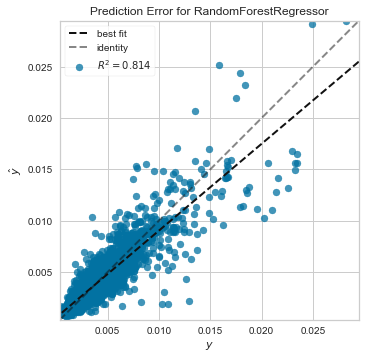

In [25] used 6.8945 MiB RAM in 0.61s, peaked 0.00 MiB above current, total RAM usage 439.11 MiB


In [25]:
try:
    if X_test.shape[0] > 0:
        from yellowbrick.regressor import PredictionError
        visualizer = PredictionError(est)
        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        ax_subplot = visualizer.show()        
except ModuleNotFoundError:
    print('no yellowbrick')

In [26]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
if 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
0.716272,log_return1_linear_weight
0.116127,log_return1
0.028613,log_return2
0.018641,size
0.011928,bid_size1_var
0.010146,bid_size2_var
0.010023,ask_size1_mean
0.009283,ask_size1_var
0.009136,ask_size2_var


In [26] used 0.1797 MiB RAM in 0.21s, peaked 0.00 MiB above current, total RAM usage 439.29 MiB


In [28]:
import shap
explainer = shap.Explainer(est)

shap_values = explainer(X_test[:5])

In [28] used 105.8594 MiB RAM in 2.83s, peaked 0.00 MiB above current, total RAM usage 663.91 MiB


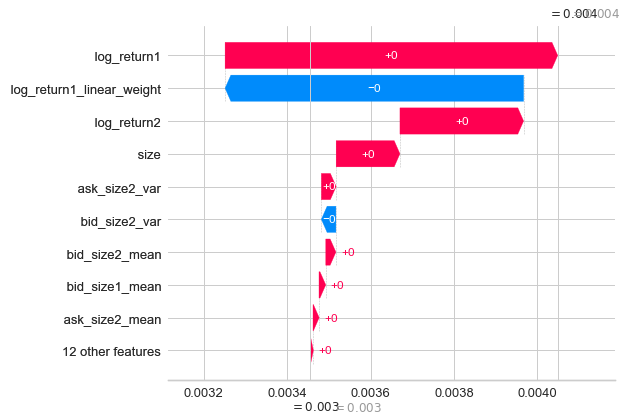

In [75] used 0.0000 MiB RAM in 0.65s, peaked 0.00 MiB above current, total RAM usage 692.15 MiB


In [75]:
# visualize the first prediction's explanation
from shap.plots import _waterfall
# https://github.com/slundberg/shap/issues/2140
_waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0].values, X_test.iloc[0] )

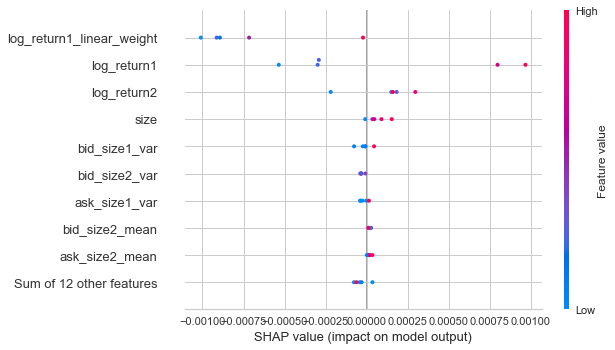

In [33] used 1.5117 MiB RAM in 0.55s, peaked 0.00 MiB above current, total RAM usage 665.43 MiB


In [33]:
shap.plots.beeswarm(shap_values)

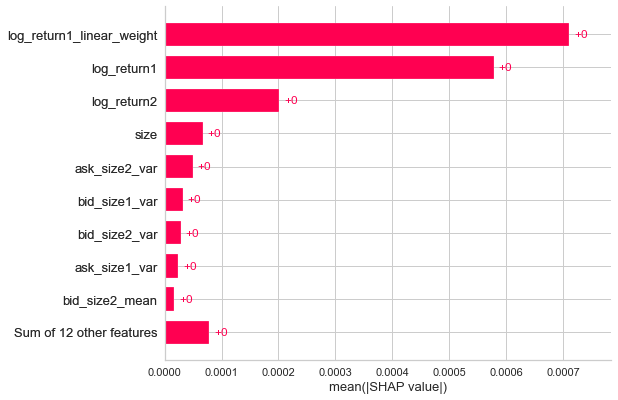

In [34] used 0.0117 MiB RAM in 0.45s, peaked 0.00 MiB above current, total RAM usage 665.44 MiB


In [34]:
shap.plots.bar(shap_values)

# Make predictions

In [ ]:
len(stock_ids) # expecting 112

In [ ]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)
df_test_all = df_test_all.set_index(['stock_id', 'time_id'])

show_details(df_test_all)

In [ ]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = load_data_build_features(stock_id, ROOT, TEST_FOLDER, cols, df_test_all)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

In [ ]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)
show_details(df_test_predictions)
print(f'Notebook took {datetime.datetime.utcnow()-t1_notebook_start} to run')

In [ ]:
if not ENV_HOME:
    assert USE_ALL_STOCK_IDS, "If we're on Kaggle but not using all stock_ids, we're not ready to submit, so fail here to remind me to change USSE_ALL_STOCK_IDS!"

In [ ]:
if False:
    print(f'Iterating over {len(stock_ids)} stocks:')
    all_train_merged = []
    for stock_id in tqdm(stock_ids):
        assert isinstance(stock_id, int)
        df_book_train_stock_X = pd.read_parquet(
            os.path.join(ROOT, f"book_train.parquet/stock_id={stock_id}")
        )
        df_book_train_stock_X["stock_id"] = stock_id
        df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
        assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)

        cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1']
        features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
        #print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
        features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)

        # inner join, so we just get the subset
        df_train_stock_X = df_train_all.query('stock_id == @stock_id')
        to_merge = [df_train_stock_X, features_var1, features_mean1]
        row_lengths = [df.shape[0] for df in to_merge]
        assert len(set(row_lengths)) == 1, row_lengths # should all be same length
        train_merged = pd.concat(to_merge, axis=1)
        all_train_merged.append(train_merged)

In [ ]:
if False:
    #for stock_id in tqdm(stock_ids_test):
    if False:
        parquet_filename = os.path.join(ROOT, f'{TEST_FOLDER}/stock_id={stock_id}')
        #print(f"reading {parquet_filename}")
        df_book_test_stock_X = pd.read_parquet(parquet_filename)
        df_book_test_stock_X['stock_id'] = stock_id
        features_var1_test = make_features_stats(df_book_test_stock_X, 'var', cols)
        features_mean1_test = make_features_stats(df_book_test_stock_X, 'mean', cols)

        df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
        test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
        test_merged = pd.merge(test_merged, features_mean1_test, left_index=True, right_index=True)
        #test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
        test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
        df_test_all_X['target'] = test_set_predictions_X
        df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
